In [1]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve, cumulative_gain_curve
import seaborn as sns

Target: Predict customers who buy bancassurance

In [25]:
data = pd.read_csv('data_true.csv')
pd.options.display.max_columns=70
data.head()

,CUSTOMER_NUMBER,CLIENT_SEX,AGE,STAFF_VIB,EB_REGISTER_CHANNEL,SMS,VERIFY_METHOD,TRANS_NO_MEAN,TRANS_NO_MAX,TRANS_NO_MIN,TRANS_NO_MEDIAN,TRANS_NO_SUM,TRANS_AMOUNT_MEAN,TRANS_AMOUNT_MAX,TRANS_AMOUNT_MIN,TRANS_AMOUNT_MEDIAN,TRANS_AMOUNT_SUM,TRANS_DAY_OF_WEEK,ACTIVITY_NO_MEAN,ACTIVITY_NO_MAX,ACTIVITY_MIN,ACTIVITY_MEDIAN,ACTIVITY_SUM,ACTI_DAY_OF_WEEK,COUNT_CA_ACCT_MEAN,COUNT_CA_ACCT_MAX,COUNT_CA_ACCT_MIN,COUNT_CA_ACCT_MEDIAN,COUNT_CA_ACCT_SUM,AVG_CA_BALANCE_MEAN,AVG_CA_BALANCE_MAX,AVG_CA_BALANCE_MIN,AVG_CA_BALANCE_MEDIAN,AVG_CA_BALANCE_SUM,COUNT_TD_ACCT_MEAN,COUNT_TD_ACCT_MAX,COUNT_TD_ACCT_MIN,COUNT_TD_ACCT_MEDIAN,COUNT_TD_ACCT_SUM,AVG_TD_BALANCE_MEAN,AVG_TD_BALANCE_MAX,AVG_TD_BALANCE_MIN,AVG_TD_BALANCE_MEDIAN,AVG_TD_BALANCE_SUM,COUNT_OF_LOAN_MEAN,COUNT_OF_LOAN_MAX,COUNT_OF_LOAN_MIN,COUNT_OF_LOAN_MEDIAN,COUNT_OF_LOAN_SUM,AVG_LOAN_AMOUNT_MEAN,AVG_LOAN_AMOUNT_MAX,AVG_LOAN_AMOUNT_MIN,AVG_LOAN_AMOUNT_MEDIAN,AVG_LOAN_AMOUNT_SUM,COUNT_CREDITCARD_MEAN,COUNT_CREDITCARD_MAX,COUNT_CREDITCARD_MIN,COUNT_CREDITCARD_MEDIAN,COUNT_CREDITCARD_SUM,COUNT_DEBITCARD_MEAN,COUNT_DEBITCARD_MAX,COUNT_DEBITCARD_MIN,COUNT_DEBITCARD_MEDIAN,COUNT_DEBITCARD_SUM,LABEL
0,639362,M,23.0,N,BRANCH,Y,SMS,1.00000,1.0,1.0,1.0,13.0,1.633154e+06,10000000.0,20000.0,400000.0,21231000.0,Thu,1.373134,4.0,1.0,1.0,92.0,Thu,1.0,1.0,1.0,1.0,9.0,1.653585e+06,9371139.87,32600.00,99533.330,14882263.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,9.0,1
1,452440,M,20.0,N,BRANCH,Y,SMART_OTP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.055556,56.0,1.0,2.0,327.0,Fri,1.0,1.0,1.0,1.0,12.0,1.336710e+05,188607.14,78645.16,134387.095,1604052.29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,12.0,0
2,326290,F,23.0,N,BRANCH,Y,SMS,1.06383,2.0,1.0,1.0,50.0,1.846796e+06,15181000.0,10000.0,690000.0,86799392.0,Tue,1.733711,10.0,1.0,1.0,612.0,Tue,1.0,1.0,1.0,1.0,8.0,3.068100e+06,9961109.68,15774.19,2090890.075,24544797.28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,8.0,1
3,20802,M,27.0,N,BRANCH,Y,SMART_OTP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,0
4,114244,M,46.0,N,BRANCH,N,SMS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,10.0,1.971582e+05,226368.00,12903.23,226368.000,1971581.98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,4.0,295312500.0,300000000.0,290625000.0,295312500.0,1.181250e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


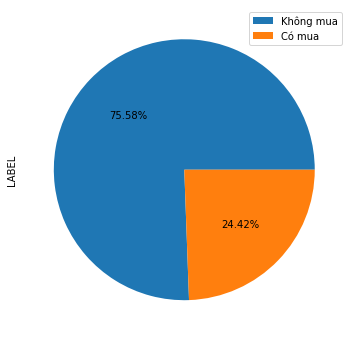

In [ ]:
data.LABEL.value_counts().plot.pie(autopct='%.2f%%', labels=None, figsize=(10,6))
plt.legend(['Không mua', 'Có mua'])

In [91]:
data.shape

(290223, 65)

In [92]:
data.columns

Index(['CUSTOMER_NUMBER', 'CLIENT_SEX', 'AGE', 'STAFF_VIB',
       'EB_REGISTER_CHANNEL', 'SMS', 'VERIFY_METHOD', 'TRANS_NO_MEAN',
       'TRANS_NO_MAX', 'TRANS_NO_MIN', 'TRANS_NO_MEDIAN', 'TRANS_NO_SUM',
       'TRANS_AMOUNT_MEAN', 'TRANS_AMOUNT_MAX', 'TRANS_AMOUNT_MIN',
       'TRANS_AMOUNT_MEDIAN', 'TRANS_AMOUNT_SUM', 'TRANS_DAY_OF_WEEK',
       'ACTIVITY_NO_MEAN', 'ACTIVITY_NO_MAX', 'ACTIVITY_MIN',
       'ACTIVITY_MEDIAN', 'ACTIVITY_SUM', 'ACTI_DAY_OF_WEEK',
       'COUNT_CA_ACCT_MEAN', 'COUNT_CA_ACCT_MAX', 'COUNT_CA_ACCT_MIN',
       'COUNT_CA_ACCT_MEDIAN', 'COUNT_CA_ACCT_SUM', 'AVG_CA_BALANCE_MEAN',
       'AVG_CA_BALANCE_MAX', 'AVG_CA_BALANCE_MIN', 'AVG_CA_BALANCE_MEDIAN',
       'AVG_CA_BALANCE_SUM', 'COUNT_TD_ACCT_MEAN', 'COUNT_TD_ACCT_MAX',
       'COUNT_TD_ACCT_MIN', 'COUNT_TD_ACCT_MEDIAN', 'COUNT_TD_ACCT_SUM',
       'AVG_TD_BALANCE_MEAN', 'AVG_TD_BALANCE_MAX', 'AVG_TD_BALANCE_MIN',
       'AVG_TD_BALANCE_MEDIAN', 'AVG_TD_BALANCE_SUM', 'COUNT_OF_LOAN_MEAN',
       'COUNT_O

In [93]:
data.rename(columns={'ACTIVITY_MIN':'ACTIVITY_NO_MIN','ACTIVITY_MEDIAN':'ACTIVITY_NO_MEDIAN','ACTIVITY_SUM':'ACTIVITY_NO_SUM'})

,CUSTOMER_NUMBER,CLIENT_SEX,AGE,STAFF_VIB,EB_REGISTER_CHANNEL,SMS,VERIFY_METHOD,TRANS_NO_MEAN,TRANS_NO_MAX,TRANS_NO_MIN,...,COUNT_CREDITCARD_MAX,COUNT_CREDITCARD_MIN,COUNT_CREDITCARD_MEDIAN,COUNT_CREDITCARD_SUM,COUNT_DEBITCARD_MEAN,COUNT_DEBITCARD_MAX,COUNT_DEBITCARD_MIN,COUNT_DEBITCARD_MEDIAN,COUNT_DEBITCARD_SUM,LABEL
0,639362,M,23.0,N,BRANCH,Y,SMS,1.00000,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,9.0,1
1,452440,M,20.0,N,BRANCH,Y,SMART_OTP,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,12.0,0
2,326290,F,23.0,N,BRANCH,Y,SMS,1.06383,2.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,8.0,1
3,20802,M,27.0,N,BRANCH,Y,SMART_OTP,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,0
4,114244,M,46.0,N,BRANCH,N,SMS,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290218,174454,F,22.0,N,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
290219,195828,F,20.0,N,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
290220,234465,M,45.0,N,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
290221,119456,M,24.0,N,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,9.0,0


In [94]:
data.EB_REGISTER_CHANNEL.unique()

array(['BRANCH', 'MYVIB', 'AUTO-JOB', 'WEBSITE', nan], dtype=object)

In [95]:
data.LABEL.value_counts()

0    219348
1     70875
Name: LABEL, dtype: int64

### TRAIN TEST SPLIT

In [96]:
dataset = data.drop(columns=['CUSTOMER_NUMBER'])

In [97]:
categorical_col = dataset.select_dtypes(exclude=[int, float, np.int64, np.float64]).columns.to_list()

In [98]:
categorical_col

['CLIENT_SEX',
 'STAFF_VIB',
 'EB_REGISTER_CHANNEL',
 'SMS',
 'VERIFY_METHOD',
 'TRANS_DAY_OF_WEEK',
 'ACTI_DAY_OF_WEEK']

In [99]:
for cat_col in categorical_col:
    dataset[cat_col] = dataset[cat_col].astype('category')

In [100]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop(columns='LABEL'), dataset.LABEL, 
                                                    test_size=0.1, shuffle=True, stratify=dataset.LABEL, 
                                                    random_state=4)
valid_size = y_test.shape[0] / y_train.shape[0]

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, 
                                                    test_size=valid_size, shuffle=True, stratify=y_train, 
                                                    random_state=4)

In [101]:
y_test

208431    0
236677    0
6725      0
266949    0
133672    0
         ..
268960    0
216868    0
94675     0
81050     0
210436    0
Name: LABEL, Length: 29023, dtype: int64

In [102]:
dataset.shape[0]

290223

In [103]:
y_test.shape[0]

29023

In [104]:
y_train.shape[0]

232177

In [105]:
y_test.shape[0]/y_train.shape[0]

0.12500376867648388

In [106]:
y_train.shape[0]*0.12500376867648388/290223

0.10000241193840599

#### TRAINING

In [107]:
categorical_col

['CLIENT_SEX',
 'STAFF_VIB',
 'EB_REGISTER_CHANNEL',
 'SMS',
 'VERIFY_METHOD',
 'TRANS_DAY_OF_WEEK',
 'ACTI_DAY_OF_WEEK']

In [108]:
train_set = lgb.Dataset(X_train, y_train)
valid_set = lgb.Dataset(X_valid, y_valid)

In [ ]:
params = {
    'boosting_type': 'gbdt',#Decision Tree
    'objective': 'binary',#Phân loại 2 
    'learning_rate': 0.001, #Tốc độ học của mô hình
    'metric': ['binary_logloss', 'auc'],
    'max_depth': 5,#5 lần chia
    'num_leaves': 10, #mỗi lần chia tách ra làm 
    'feature_fraction' : 0.8, #một lần training, lấy bao nhiêu phần trăm trong tổng số cột
    'bagging_fraction' : 0.8, #Lấy bao nhiêu % số dòng
    'min_data_in_leaf' : 1000, #Số lượng điểm dữ liệu trong 1 leaf
    'num_threads': 8 #Số luồng chạy trong máy tính
}

eval_result = {}

clf = lgb.train(params, train_set, num_boost_round=4000 #số cây
                , categorical_feature=categorical_col,
                valid_sets=[train_set, valid_set], 
                verbose_eval=False
                , evals_result=eval_result)

c:\users\pc\anaconda3\envs\thuantran\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ACTI_DAY_OF_WEEK', 'CLIENT_SEX', 'EB_REGISTER_CHANNEL', 'SMS', 'STAFF_VIB', 'TRANS_DAY_OF_WEEK', 'VERIFY_METHOD']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[LightGBM] [Info] Number of positive: 56699, number of negative: 175478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7779
[LightGBM] [Info] Number of data points in the train set: 232177, number of used features: 63


c:\users\pc\anaconda3\envs\thuantran\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\users\pc\anaconda3\envs\thuantran\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.244206 -> initscore=-1.129757
[LightGBM] [Info] Start training from score -1.129757


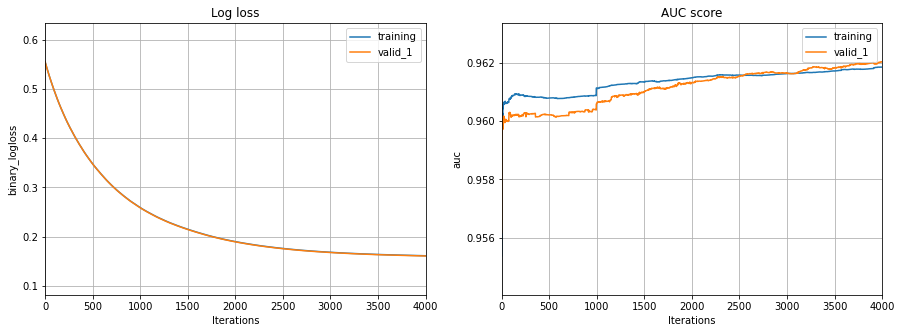

In [110]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
lgb.plot_metric(eval_result, metric='binary_logloss', ax=ax[0], title='Log loss')
lgb.plot_metric(eval_result, metric='auc', ax=ax[1], title='AUC score');

### PREDICTION AND EVALUATION

In [111]:
y_predicted = clf.predict(X_test)

In [112]:
roc_auc_score(y_test, y_predicted)

0.9610736767928638

In [113]:
thresh = 0.5
y_hard_predicted = np.where(y_predicted >= 0.5, 1, 0)

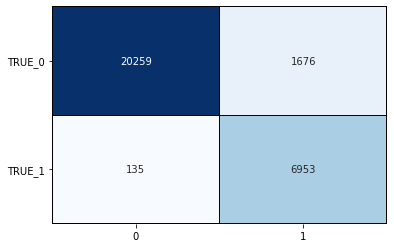

In [114]:
ax = sns.heatmap(confusion_matrix(y_test,  y_hard_predicted), cbar=False, cmap='Blues', annot=True, fmt='d', 
            xticklabels=['0', '1'], yticklabels=['TRUE_0', 'TRUE_1'], 
            linewidth=0.1, linecolor='black')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right');

In [115]:
1676+6953

8629

In [116]:
print(classification_report(y_test, y_hard_predicted))

              precision    recall  f1-score   support

           0       0.99      0.92      0.96     21935
           1       0.81      0.98      0.88      7088

    accuracy                           0.94     29023
   macro avg       0.90      0.95      0.92     29023
weighted avg       0.95      0.94      0.94     29023



### CALIBRATION CURVE

In [117]:
prob_true, prob_pred = calibration_curve(y_test, y_predicted, n_bins=10)

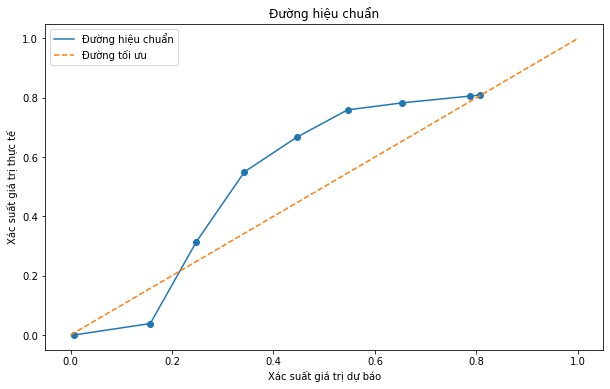

In [118]:
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true)
plt.scatter(prob_pred, prob_true)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Xác suất giá trị dự báo')
plt.ylabel('Xác suất giá trị thực tế')
plt.title('Đường hiệu chuẩn')
plt.legend(['Đường hiệu chuẩn','Đường tối ưu'])
plt.show()

### CONVERSION RATE

In [119]:
def conversion_rate(y_true, y_pred, top=0.1):
    df = pd.DataFrame({'actual': y_true, 'predicted': y_pred})
    df.sort_values('predicted', ascending=False)
    
    if top < 1:
        top = int(top * df.shape[0])
    df_top = df.head(top)
    return df_top.actual.sum() / df_top.shape[0]

In [120]:
conversion_rate(y_test, y_predicted)

0.23673328738800828

### IMPORTANT FEATURE

Text(0.5, 1.0, 'Biến quan trọng')

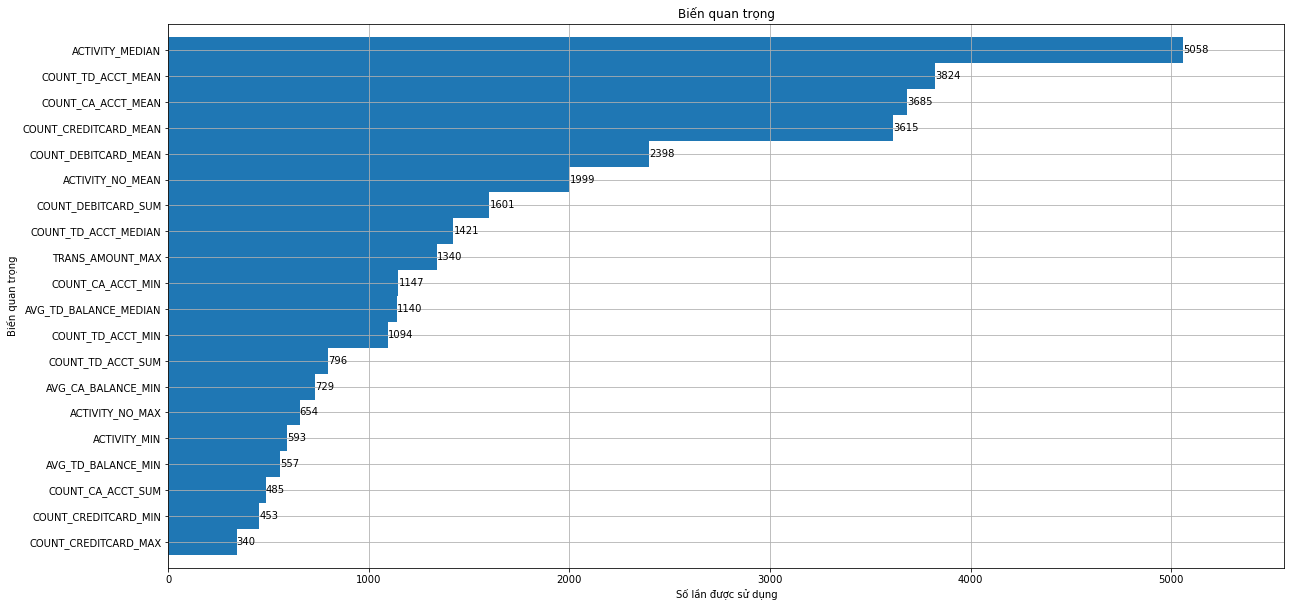

In [121]:
lgb.plot_importance(clf, precision=0, max_num_features=20, figsize=(20, 10), height=1)
plt.xlabel('Số lần được sử dụng')
plt.ylabel('Biến quan trọng')
plt.title('Biến quan trọng')

### GAIN TABLE

In [140]:
def gain_table(y_true, y_pred):
    pdt = pd.DataFrame({'label':y_true,'predict':y_pred})
    
    num_label = pd.qcut(pdt['predict'], 10, labels=False, duplicates='drop').nunique()
    
    label_levels= ['Level1','Level2','Level3','Level4','Level5','Level6', 'Level7','Level8','Level9','Level10']
    pdt['level'], bins=pd.qcut(pdt['predict'], 10, labels=label_levels[: num_label], 
                               duplicates='drop',retbins=True)
    
    pdt2 = pdt.groupby(['level']).agg(Số_lượng_khách_hàng=('label','count'),
                                      Số_người_mua_bảo_hiểm=('label','sum'),
                                      Xác_suất_mua_nhỏ_nhất=('predict','min'),
                                      Xác_suất_mua_lớn_nhất=('predict','max')
                                     ).reset_index().sort_values('level',ascending=False)

    pdt2['Tỷ_lệ_chuyển_đổi']= pdt2['Số_người_mua_bảo_hiểm']/pdt2['Số_lượng_khách_hàng']
    return pdt2.set_index('level')

In [141]:
index = ['cấp_độ_1','cấp_độ_2','cấp_độ_3','cấp_độ_4','cấp_độ_5','cấp_độ_6','cấp_độ_7','cấp_độ_8','cấp_độ_9']

In [142]:
df = gain_table(y_test, y_predicted)
df

,Số_lượng_khách_hàng,Số_người_mua_bảo_hiểm,Xác_suất_mua_nhỏ_nhất,Xác_suất_mua_lớn_nhất,Tỷ_lệ_chuyển_đổi
level,,,,,
Level9,2903,2341,0.796453,0.836700,0.806407
Level8,2757,2210,0.793738,0.796359,0.801596
Level7,3047,2451,0.351088,0.793735,0.804398
Level6,2902,86,0.012195,0.349605,0.029635
Level5,2431,0,0.005798,0.012188,0.000000
Level4,1973,0,0.005779,0.005795,0.000000
Level3,4153,0,0.005071,0.005775,0.000000
Level2,1743,0,0.005025,0.005068,0.000000
Level1,7114,0,0.004975,0.005020,0.000000


In [143]:
df.index=index

In [146]:
y_test.shape

(29023,)

In [148]:
29023-2903-2757

23363

In [144]:
df

,Số_lượng_khách_hàng,Số_người_mua_bảo_hiểm,Xác_suất_mua_nhỏ_nhất,Xác_suất_mua_lớn_nhất,Tỷ_lệ_chuyển_đổi
cấp_độ_1,2903,2341,0.796453,0.836700,0.806407
cấp_độ_2,2757,2210,0.793738,0.796359,0.801596
cấp_độ_3,3047,2451,0.351088,0.793735,0.804398
cấp_độ_4,2902,86,0.012195,0.349605,0.029635
cấp_độ_5,2431,0,0.005798,0.012188,0.000000
cấp_độ_6,1973,0,0.005779,0.005795,0.000000
cấp_độ_7,4153,0,0.005071,0.005775,0.000000
cấp_độ_8,1743,0,0.005025,0.005068,0.000000
cấp_độ_9,7114,0,0.004975,0.005020,0.000000


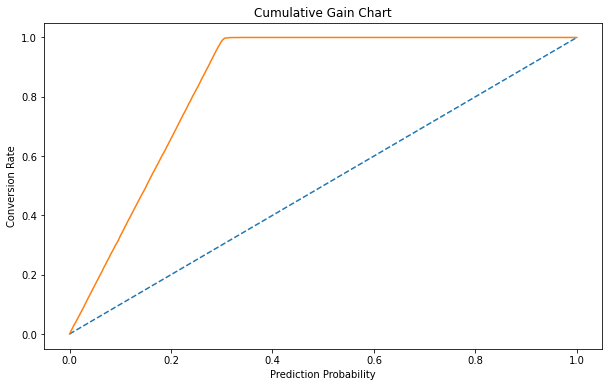

In [145]:
percentage, gain = cumulative_gain_curve(y_test, y_predicted)
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(percentage, gain)
plt.xlabel('Prediction Probability')
plt.ylabel('Conversion Rate')
plt.title('Cumulative Gain Chart')
plt.show()

# DRAFT

In [10]:
trans = pd.read_csv('2.Data_MyVIB_Transaction.csv')
trans.head()

,TRANS_LV1,TRANS_LV2,TRANS_DATE,DAY_OF_WEEK,TRANS_HOUR,TRANS_NO,TRANS_AMOUNT,CUSTOMER_NUMBER
0,Transfer,Outside_VIB,2019-01-03,Thu,17,2,189771864.0,701619
1,Transfer,Outside_VIB,2019-07-01,Mon,13,2,30224900.0,701619
2,Transfer,Outside_VIB,2019-01-02,Wed,15,1,100000.0,701619
3,Payment,Credit_card_repayment,2019-01-03,Thu,14,1,85000000.0,262123
4,Payment,Credit_card_repayment,2019-01-28,Mon,22,1,83000000.0,262123


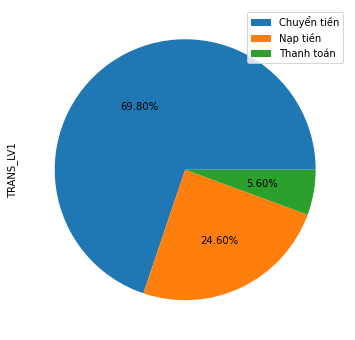

In [13]:
trans.TRANS_LV1.value_counts().plot.pie(autopct='%.2f%%', figsize=(10,6), labels=None)
plt.legend(['Chuyển tiền', 'Nạp tiền', 'Thanh toán']);

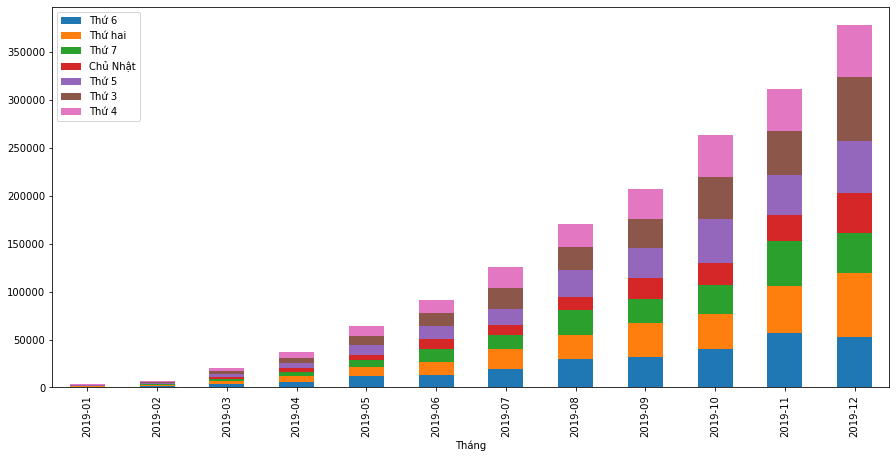

In [84]:
(
    trans
    .groupby(['MONTHLY','DAY_OF_WEEK'])
    .TRANS_NO
    .sum()
    .unstack('DAY_OF_WEEK')
    .plot
    .bar(stacked=True, figsize=(15,7))
)
plt.legend(['Thứ 6', 'Thứ hai', 'Thứ 7', 'Chủ Nhật', 'Thứ 5', 'Thứ 3', 'Thứ 4'])
plt.xlabel('Tháng');

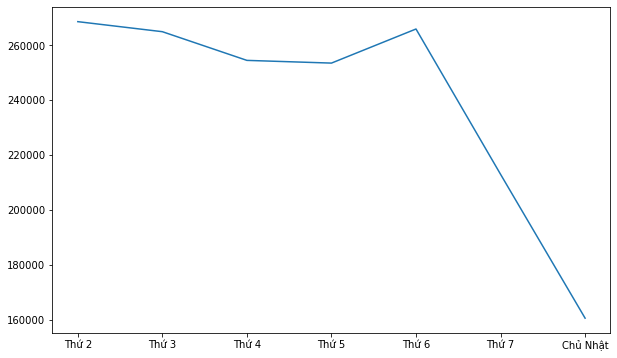

In [53]:
dic = pd.Series({'Thứ 2':268559, 'Thứ 3':264902,'Thứ 4': 254454, 'Thứ 5':253465, 'Thứ 6': 265882, 'Thứ 7':  212969, 'Chủ Nhật': 160560 })
dic.plot(figsize=(10,6));

In [99]:
(
    trans
    .groupby(['CUSTOMER_NUMBER','MONTHLY'])
    .TRANS_NO
    .sum()
    .groupby('CUSTOMER_NUMBER')
    .mean()
    .describe()
)

count    52488.000000
mean         6.756823
std         16.659039
min          1.000000
25%          2.000000
50%          3.777778
75%          7.571429
max        912.833333
Name: TRANS_NO, dtype: float64

In [100]:
(
    trans
    .groupby(['MONTHLY','CUSTOMER_NUMBER'])
    .TRANS_NO
    .sum()
    .groupby('MONTHLY')
    .mean()
    .describe()
)

count    12.000000
mean      7.298110
std       1.977924
min       3.893460
25%       5.997888
50%       7.831830
75%       8.858688
max       9.424849
Name: TRANS_NO, dtype: float64

In [93]:
trans.query('CUSTOMER_NUMBER==747140')

,TRANS_LV1,TRANS_LV2,TRANS_DATE,DAY_OF_WEEK,TRANS_HOUR,TRANS_NO,TRANS_AMOUNT,CUSTOMER_NUMBER,MONTHLY
313775,Transfer,Outside_VIB,2019-05-12,Sun,21,15,73754200.0,747140,2019-05
313776,Transfer,Outside_VIB,2019-05-09,Thu,21,8,23210000.0,747140,2019-05
313777,Transfer,Outside_VIB,2019-05-11,Sat,20,14,116023900.0,747140,2019-05
313778,Transfer,Outside_VIB,2019-05-15,Wed,16,10,41980150.0,747140,2019-05
313779,Transfer,Outside_VIB,2019-05-16,Thu,20,1,4950000.0,747140,2019-05
...,...,...,...,...,...,...,...,...,...
314309,Transfer,Outside_VIB,2019-09-23,Mon,10,12,7662000.0,747140,2019-09
314310,Transfer,Outside_VIB,2019-09-23,Mon,12,15,31340909.0,747140,2019-09
314311,Transfer,Outside_VIB,2019-09-24,Tue,10,1,50490000.0,747140,2019-09
314312,Transfer,Outside_VIB,2019-09-26,Thu,6,9,20037000.0,747140,2019-09


In [28]:
trans.TRANS_DATE.dtype

dtype('O')

In [29]:
trans.isnull().sum()

TRANS_LV1          0
TRANS_LV2          0
TRANS_DATE         0
DAY_OF_WEEK        0
TRANS_HOUR         0
TRANS_NO           0
TRANS_AMOUNT       0
CUSTOMER_NUMBER    0
dtype: int64

In [30]:
trans['MONTHLY'] = trans.TRANS_DATE.apply(lambda x: x[:7])

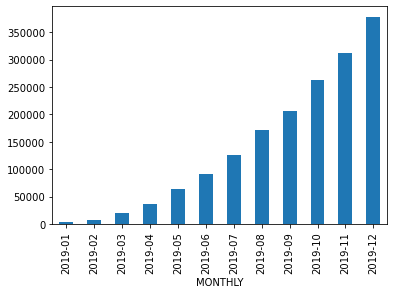

In [36]:
(
    trans
    .groupby('MONTHLY')
    .TRANS_NO
    .sum()
    .plot
    .bar()
);

In [85]:
active = pd.read_csv('3.Data_MyVIB_Activity.csv')
active.head()

,ACTIVITY_DATE,DAY_OF_WEEK,ACTIVITY_HOUR,ACTIVITY_NO,CUSTOMER_NUMBER,ACTIVITY_NAME
0,1/22/2019,Tue,20,2,630178,MB_INTEREST_RATE_VIEW
1,1/10/2019,Thu,18,16,630178,MB_INTEREST_RATE_VIEW
2,1/26/2019,Sat,17,15,630178,MB_INTEREST_RATE_VIEW
3,1/2/2019,Wed,9,27,630178,MB_INTEREST_RATE_VIEW
4,1/19/2019,Sat,8,3,630178,MB_INTEREST_RATE_VIEW


In [86]:
active.ACTIVITY_NAME.value_counts()

LOGIN                            3638224
LOGOUT                           3499251
QUERY_ACCOUNT_INFORMATION        2566128
MB_INTEREST_RATE_VIEW            2448877
TRANSACTION_OVERVIEW_QUERY       1079162
LOGIN_FINGER                      784355
TRANSFER_VIA_SML                  679219
LOGIN_FACEID                      237933
TRANSFER_VIB_ACCOUNT              216639
TOPUP_MOBILE                      206441
MB_LOCATION_POS_VIEW              184072
MB_ACCOUNT_QUICK_BALANCE          170850
AUTHENTICATION                    144475
MB_SET_PIN                         69744
MB_BILLPAY                         34703
TRANSFER_VIA_PAYMENT_CENTER        31443
MB_LOCATION_BRANCH_VIEW            28239
CHANGE_PASSWORD                    26410
TRANSFER_VIA_SML_ACCOUNT           20358
MB_LOCATION_ATM_VIEW               17996
TRANSACTION_DETAIL_QUERY           15658
MB_CHANGE_PIN                       8028
MB_RESET_PIN                        7496
MB_EXCHANGE_RATE_VIEW               5618
QUERY_CURRENT_AC

In [105]:
from datetime import datetime

In [108]:
active['ACTIVITY_DATE'] = active.ACTIVITY_DATE.apply(lambda x: datetime.strptime(x,'%m/%d/%Y'))

In [111]:
active['MONTHLY'] = active.ACTIVITY_DATE.apply(lambda x: datetime.strftime(x,'%Y%m'))

In [112]:
active

,ACTIVITY_DATE,DAY_OF_WEEK,ACTIVITY_HOUR,ACTIVITY_NO,CUSTOMER_NUMBER,ACTIVITY_NAME,MONTHLY
0,2019-01-22,Tue,20,2,630178,MB_INTEREST_RATE_VIEW,201901
1,2019-01-10,Thu,18,16,630178,MB_INTEREST_RATE_VIEW,201901
2,2019-01-26,Sat,17,15,630178,MB_INTEREST_RATE_VIEW,201901
3,2019-01-02,Wed,9,27,630178,MB_INTEREST_RATE_VIEW,201901
4,2019-01-19,Sat,8,3,630178,MB_INTEREST_RATE_VIEW,201901
...,...,...,...,...,...,...,...
16132670,2019-11-01,Fri,11,1,327258,TRANSFER_VIB_ACCOUNT_BULK,201911
16132671,2019-12-02,Mon,15,1,327258,TRANSFER_VIB_ACCOUNT_BULK,201912
16132672,2019-11-19,Tue,17,1,882344,TRANSFER_VIB_ACCOUNT_BULK,201911
16132673,2019-11-13,Wed,10,5,199908,RB_BILLPAY_PSTN,201911


In [118]:
(
    active
    .groupby(['DAY_OF_WEEK'])
    .ACTIVITY_NO
    .sum()
)

DAY_OF_WEEK
Fri    5695089
Mon    5522257
Sat    4461558
Sun    3145225
Thu    5217465
Tue    5480067
Wed    5217316
Name: ACTIVITY_NO, dtype: int64

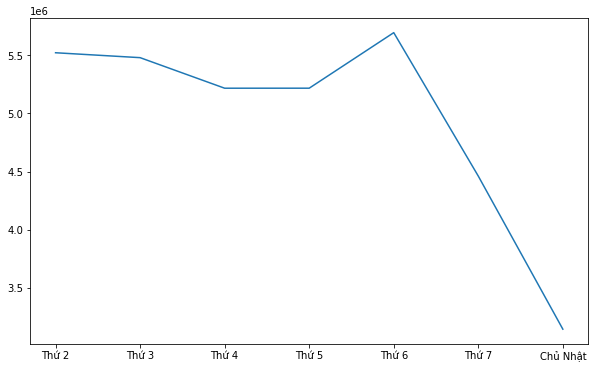

In [119]:
dic = pd.Series({'Thứ 2':5522257, 'Thứ 3':5480067,'Thứ 4': 5217316, 'Thứ 5':5217465, 'Thứ 6': 5695089, 'Thứ 7':  4461558, 'Chủ Nhật': 3145225 })
dic.plot(figsize=(10,6));

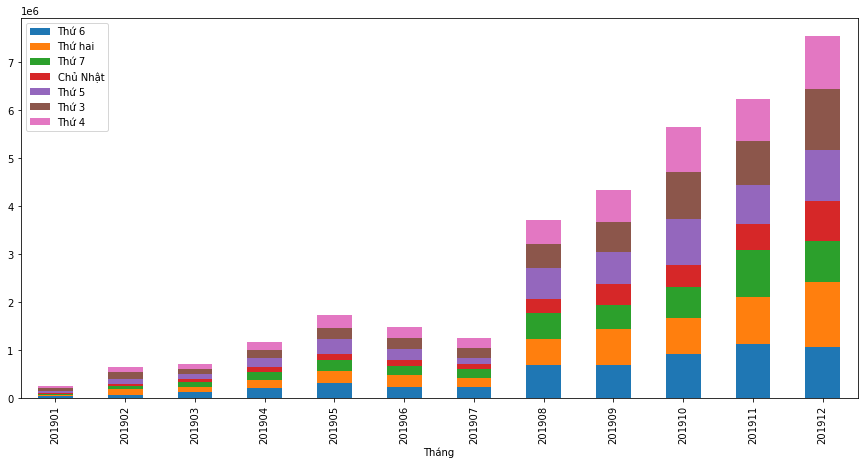

In [114]:
(
    active
    .groupby(['MONTHLY','DAY_OF_WEEK'])
    .ACTIVITY_NO
    .sum()
    .unstack('DAY_OF_WEEK')
    .plot
    .bar(stacked=True, figsize=(15,7))
)
plt.legend(['Thứ 6', 'Thứ hai', 'Thứ 7', 'Chủ Nhật', 'Thứ 5', 'Thứ 3', 'Thứ 4'])
plt.xlabel('Tháng');

In [121]:
(
    active
    .groupby(['CUSTOMER_NUMBER','MONTHLY'])
    .ACTIVITY_NO
    .sum()
    .groupby('CUSTOMER_NUMBER')
    .mean()
    .describe()
)

count    77741.000000
mean        96.935392
std        126.357949
min          1.000000
25%         32.000000
50%         63.400000
75%        118.000000
max       6002.000000
Name: ACTIVITY_NO, dtype: float64